# MRMS Hovmöller Diagram

This Python notebook plots Multi-Radar Multi-Sensor (MRMS) data on a Hovmöller-type diagram, with longitude plotted on the x-axis and time plotted on the y-axis.

**Created by: Ezekiel Caldon (SUNY Oswego) as part of the Lake-Effect Electrification (NSF-LEE) Project, funded by the National Science Foundation, grant number 2212177**

## Import statements & configuration of web clients & map features

In [1]:
%matplotlib inline
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmweather
import datetime as dt
from datetime import datetime, timedelta
import glob
import gzip
import os
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from metpy.plots import USCOUNTIES
import os
import numpy as np
import pandas as pd
import requests
import shutil
import xarray as xr

s3=boto3.client('s3', config=Config(signature_version=UNSIGNED))

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='110m',
    facecolor='none',linewidth=5)

os.environ["ECCODES_LOG_DISABLED"] = "1"

## Customize the plot


There are over 200 different fields that can be plotted using the MRMS database, [this directory in the AWS S3 bucket shows all of the options.](https://noaa-mrms-pds.s3.amazonaws.com/index.html#CONUS/) Copy the name of the directory without the slash in the `field` variable to utilize the desired field.

In [2]:
# Start & end times for plot
start_time = dt.datetime(2022, 11, 20, 10)
end_time = dt.datetime(2022, 11, 20, 23)

# Lat/lon box for plot
lat_min = 43.45
lat_max = 43.46
lon_min = 283
lon_max = 285

x_ticks = [283, 283.5, 284, 284.5, 285]

# Lat/lon box for context plot
context_lat_min = 42
context_lat_max = 46
context_lon_min = 280
context_lon_max = 286

# Y-tick times for diagram
event_times = [dt.datetime(2022, 11, 20, 10),
               dt.datetime(2022, 11, 20, 12), 
               dt.datetime(2022, 11, 20, 23)]

# Y-tick names for diagram
event_names = ['IOP3\n11-20 10:00', 
               '11-20 12:00', 
               '11-20 23:00']

# Y-ticks to format with red color
colored_event_indices = [0, 2]

field = 'MergedReflectivityQCComposite_00.50' # MRMS Field to be plotted
cbar_label = "Reflectivity (dBZ)"

left_title = 'Multi-Radar Multi-Sensor Composite Reflectivity Hovmöller Diagram'
right_title = 'Lat: {:.1f}–{:.1f}°N'.format(lat_min, lat_max)

frequency = timedelta(minutes=2) # Frequency of MRMS plot
time_range = 12

gate_filter_num = 12 # Gate filter

min_events_per_flash = 10 # Minimum number of sources per flash
min_stations = 6 # more stations = more confident it's a good solution
max_chi = 1 # lower chi^2 = more confident it's a good solution

## Plot the context plot

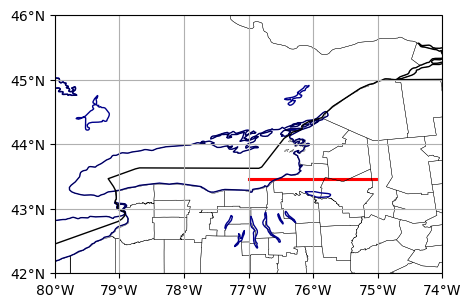

In [3]:
plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([context_lon_min, 
               context_lon_max, 
               context_lat_min, 
               context_lat_max])
ax.add_feature(USCOUNTIES.with_scale('500k'), linewidth=0.25)
ax.add_feature(cfeature.LAKES, 
               facecolor='None',
               edgecolor='darkblue', 
               linewidth=1)
ax.add_feature(cfeature.COASTLINE,edgecolor='black',linewidth=1)
ax.add_feature(cfeature.BORDERS,edgecolor='black',linewidth=1)
ax.add_feature(states_provinces, edgecolor='black',linewidth=0.25)
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.25)

plt.xticks(np.linspace(context_lon_min-360, context_lon_max-360, 7))
plt.yticks(np.linspace(context_lat_min, context_lat_max, 5))
ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol='°'))
ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol='°'))

rect = mpatches.Rectangle((lon_min, lat_min),
                          lon_max - lon_min, 
                          lat_max - lat_min,
                          linewidth=1.5, 
                          edgecolor='red', 
                          facecolor='none',
                          transform=ccrs.PlateCarree())
ax.add_patch(rect)

plt.grid(True)
plt.savefig(f'figures/{field}-HovCon-{start_time.strftime('%Y&m%d%H')}-{lat_max}.png')
plt.show()

## Plot the Hovmöller Diagram

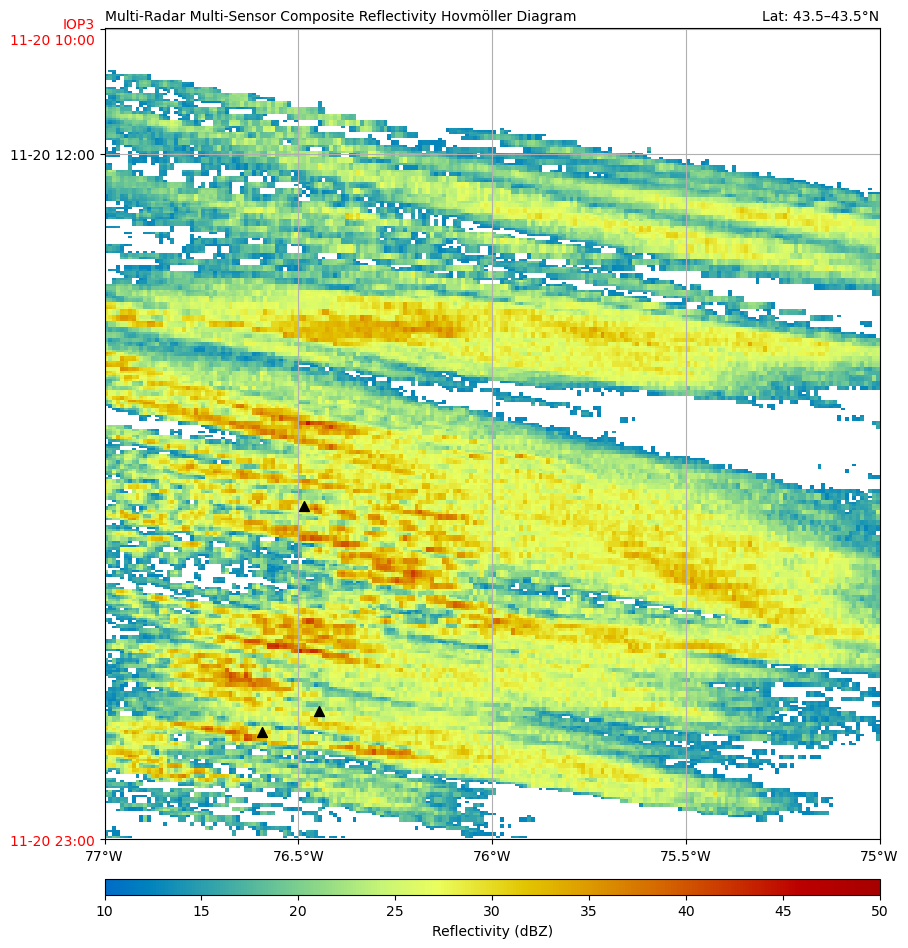

In [4]:
time = start_time
file_list = []
while (time < end_time):
    save_filename = f"mrms/{field}_{time.strftime('%Y%m%d%H%M')}.grib2.gz"
    unzip_filename = save_filename[:-3]
    if (os.path.exists(unzip_filename) == False):
        # Downloads closest MRMS file from the noaa-mrms-pds AWS S3 bucket to a
        # local directory named "mrms"
        os.makedirs("mrms", exist_ok=True)
        paginator = s3.get_paginator('list_objects_v2')
        page_iterator = paginator.paginate(Bucket='noaa-mrms-pds', 
                                           Prefix=f'CONUS/{field}/' +
                                           f'{time.strftime('%Y%m%d')}')
        selected_file = ''
        min_time_difference = dt.timedelta(minutes=(time_range/2))
        for page in page_iterator:
            for obj in page.get('Contents', []):
                current_dt = dt.datetime.strptime((obj['Key'][-24:-9]), 
                                                  "%Y%m%d-%H%M%S")
                if ((current_dt - time).days < 0):
                    current_time_difference = time - current_dt
                else:
                    current_time_difference = current_dt - time
                if (current_time_difference < min_time_difference):
                    selected_file = obj['Key']
                    min_time_difference = current_time_difference
        s3.download_file('noaa-mrms-pds', selected_file, save_filename)
        
        # Unzips the file and deletes the .zip file
        with gzip.open(save_filename, 'rb') as gz_file:
            with open(unzip_filename, 'wb') as output_file:
                shutil.copyfileobj(gz_file, output_file)
        os.remove(save_filename) 
    file_list.append(unzip_filename)
    time = time + frequency

# Read radar file

hov_data = []
times = []

for file in file_list:
    ds = xr.open_dataset(file, engine='cfgrib', decode_timedelta=True)
    refl = ds['unknown']
    lat = ds['latitude']
    lon = ds['longitude']
    
    lat_mask = (lat >= lat_min) & (lat <= lat_max)
    lon_mask = (lon >= lon_min) & (lon <= lon_max)
    
    refl_sub = refl.where(lat_mask, drop=True)
    refl_sub = refl_sub[:, lon_mask]
    
    refl_band = refl_sub.mean(dim='latitude')
    hov_data.append(refl_band)
    times.append(ds['valid_time'].values)
    
hov_array = xr.concat(hov_data, dim='time')
hov_array['time'] = times
filtered_hov = hov_array.where(hov_array > gate_filter_num)
# hov_array = hov_array.assign_coords(longitude_W = 360 - hov_array.longitude)

fig = plt.figure(figsize=(10, 13))
ax = fig.add_subplot(1,1,1)

ha = filtered_hov.plot(
    x='longitude',
    y='time',
    cmap='HomeyerRainbow',
    vmin=10, 
    vmax=50, 
    add_colorbar=False,
    ax=ax
)

filenames = []
flashes = []
flash_event_time = []
flash_events = []
selection_event = []
lma_lon = []
lma_lat = []
time = start_time
os.makedirs('lma', exist_ok=True)
while (time < end_time):
    filename = 'lma/LYLOUT_{}000_0600.dat.flash.h5'.format(time.strftime('%y%m%d_%H%M')[:-1])
    filenames.append(filename)
    if (glob.glob(filename) == []):
        url = 'https://data.nssl.noaa.gov/thredds/fileServer/WRDD/OKLMA/deployments/flashsort_6/h5_files/{}/{}'.format(time.strftime('%Y/%m/%d'),filename[4:])
        response = requests.get(url)
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f'{filename} downloaded successfully.')
    time = time + dt.timedelta(minutes=10)
    
flashes = pd.DataFrame()
flash_events = pd.DataFrame()
for filename in filenames:
    timeobj = dt.datetime.strptime(filename.split('/')[-1], 
                                   "LYLOUT_%y%m%d_%H%M%S_0600.dat.flash.h5")
    dateobj = dt.datetime.strptime(filename.split('/')[-1][:-25],
                                   "LYLOUT_%y%m%d")
    # This is the flash table
    flashes2 = pd.read_hdf(filename,'flashes/LMA_{}00_600'.format(
                                    timeobj.strftime('%y%m%d_%H%M')))
    # This is the event (VHF source) table
    flash_events2 = pd.read_hdf(filename,'events/LMA_{}00_600'.format(
                                    timeobj.strftime('%y%m%d_%H%M')))
    # Flash ID's are not unique between files. This writes new ones 
    # in the second file, if it exists
    if flashes.shape[0]>0:
        flashes2.flash_id      = flashes2['flash_id']     +flashes.flash_id.max()+1
        flashes2.start = dateobj + flashes2.start.astype('timedelta64[s]')
        flash_events2.flash_id = flash_events2['flash_id']+flashes.flash_id.max()+1
        flash_events2.time = dateobj + flash_events2.time.astype('timedelta64[s]')
    else:
        pass
    flashes      = pd.concat([flashes,flashes2])
    flash_events = pd.concat([flash_events,flash_events2])      
    
# Make a series of datetime objects for each event
# flash_event_time = np.array([dt.datetime(*time.timetuple()[:3])+dt.timedelta(seconds = j) for j in flash_events.time])
try:
    # Select all the sources meeting the criteria set above
    selection_event = (((lon_min-360)<flash_events.lon)&
                       (flash_events.lon<(lon_max-360))&
                       (lat_min<flash_events.lat)&
                       (flash_events.lat<lat_max)&
                       (flash_events.chi2<=max_chi)&
                       (flash_events.stations>=min_stations))
    
    lma_lon = (flash_events.lon[selection_event].values+360)
    
    lma_time = (flash_events.time[selection_event].values)
    lma_time = lma_time.astype('datetime64[ns]')

except AttributeError:
    pass
try:
    # Only those in flashes and meeting criteria set above
    if flash_events.empty == False:
        for flash in flashes.flash_id[flashes.n_points>=min_events_per_flash]:
            if (any ((flash_events.flash_id[selection_event]==flash) == True)):
                plt.scatter(lma_lon[(flash_events.flash_id[selection_event]==flash)][0],
                            lma_time[(flash_events.flash_id[selection_event]==flash)][0],
                            color='k',s=50, marker='^')
except NameError:
    pass

cbar = plt.colorbar(ha, 
                    orientation='horizontal', 
                    pad=0.04, 
                    aspect=50, 
                    extendrect=True)
cbar.set_label(cbar_label)
 
plt.title("")
plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
plt.xticks(x_ticks)
ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol='°'))

plt.yticks(event_times, event_names)
ax.set_xlabel('')
ax.set_ylabel('')

plt.grid(True)
plt.title('Multi-Radar Multi-Sensor Composite Reflectivity Hovmöller Diagram',
          loc='left', 
          fontsize=10)
plt.title('Lat: {:.01f}–{:.01f}°N'.format(lat_min, lat_max), 
          loc='right', 
          fontsize=10)

for i in colored_event_indices:
    ax.get_yticklabels()[i].set_color('red') 
    
plt.savefig(f'figures/{field}-HovFig-{start_time.strftime('%Y%m%d%H')}-{lat_max}.png')
plt.show()